In [2]:
%load_ext autoreload
%autoreload 2

from darts.datasets import ETTh1Dataset
import numpy as np
import pandas as pd
import torch
import random
import csv
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt
import torch
from torch.utils.data import TensorDataset, DataLoader
from torch.autograd import Variable
from torchmetrics import AUROC, Accuracy
import collections
import os

from models import LogisticRegressionWithSummariesAndBottleneck_Wrapper
from preprocess_helpers import *
from helper import *
from param_initializations import *
from optimization_strategy import greedy_selection

device = torch.device('cuda') if torch.cuda.is_available else torch.device('cpu')
device

device(type='cuda')

<Axes: xlabel='date'>

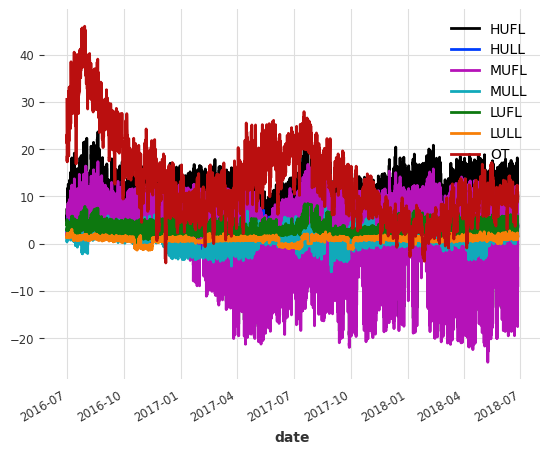

In [4]:
series = ETTh1Dataset().load()
series.plot()

<Axes: xlabel='date'>

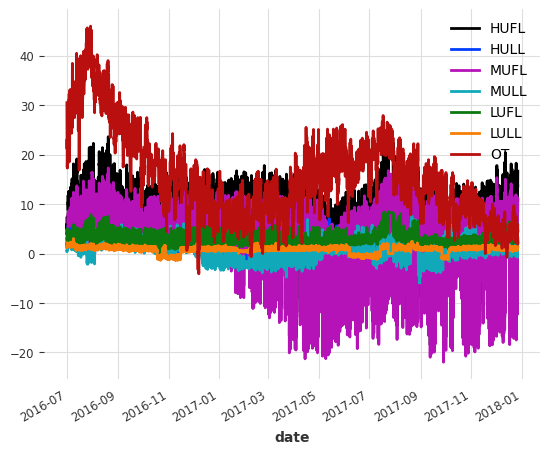

In [8]:
train, test = series.split_before(0.75)
train.plot()

In [10]:
from darts.utils.statistics import plot_acf, check_seasonality

for m in range(2, 25):
    is_seasonal, period = check_seasonality(train, m=m, alpha=0.05)
    if is_seasonal:
        print("There is seasonality of order {}.".format(period))

AssertionError: Only univariate TimeSeries instances support this method


AssertionError: Only univariate TimeSeries instances support this method

In [ ]:
lengths = []
for i, x in enumerate(X):
    lengths.append(x.shape[1])
lengths.sort()

MIN_TS_SIZE = min(lengths)
MAX_TS_SIZE = max(lengths)

print(MIN_TS_SIZE, MAX_TS_SIZE)

counter = collections.Counter(lengths)
counter


In [ ]:
def preprocess_data_binary(X, target):
    equi_length_X = []
    for x in X:
        pad_width = ((0, 0), (0, MAX_TS_SIZE - x.shape[1]))
        padded = np.pad(x, pad_width, mode='constant', constant_values=0)
        equi_length_X.append(padded)

    equi_length_X = np.array(equi_length_X)
    equi_length_X = equi_length_X.swapaxes(1,2)
    
    indicators_3d = ~np.isnan(equi_length_X)

    data = np.concatenate([equi_length_X, indicators_3d], axis=-1)
    
    ## target
    # convert problem to 1 vs all
    _y = np.copy(target)
    _y[_y > 1] = 0
    
    # convert y to logits
    y_logits = np.vstack([(~_y.astype(bool)).astype(int), _y])
    y_logits = np.swapaxes(y_logits, 0, 1)
    
    # weights
    pos_prop = np.mean(np.array(y_logits)[:, 1])
    p_weight = torch.Tensor([1 / (1 - pos_prop), 1 / pos_prop]).to(device)
    
    return data, y_logits, p_weight

def preprocess_data_multiclass(X, target):
    equi_length_X = []
    for x in X:
        pad_width = ((0, 0), (0, MAX_TS_SIZE - x.shape[1]))
        padded = np.pad(x, pad_width, mode='constant', constant_values=0)
        equi_length_X.append(padded)

    equi_length_X = np.array(equi_length_X)
    equi_length_X = equi_length_X.swapaxes(1,2)
    
    indicators_3d = ~np.isnan(equi_length_X)

    data = np.concatenate([equi_length_X, indicators_3d], axis=-1) # (N x ts_length x 2*changing_dim)
    
    ## target
    _y = np.copy(target)
    y_unique = np.unique(_y)
    num_classes = len(y_unique)
    
    # initiazing datasets
    weights = compute_class_weight(class_weight='balanced', classes=y_unique, y=_y)
    weights = torch.Tensor(weights).to(device)
    
    # 1 hot encode
    y_one_hot = np.eye(num_classes)[_y-1]
    
    return data, y_one_hot, num_classes, weights


In [ ]:
def tensor_wrap(x, klass=torch.Tensor):
    return x if 'torch' in str(type(x)) else klass(x)

def initialize_data(r, _X, _y, batch_size = 128, multiclass = False):   
    
    # train-test-split
    torch.set_printoptions(sci_mode=False)
    X_train, X_test, y_train, y_test = train_test_split(_X, _y, test_size = 0.15, random_state = r, stratify = _y)

    # train-val split
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.20, random_state = r, stratify = y_train)

    X_train_pt = Variable(tensor_wrap(X_train))#.to(device)
    y_train_pt = Variable(tensor_wrap(y_train, torch.FloatTensor))#.to(device)

    X_val_pt = Variable(tensor_wrap(X_val))#.to(device)
    y_val_pt = Variable(tensor_wrap(y_val, torch.FloatTensor))#.to(device)

    X_test_pt = Variable(tensor_wrap(X_test))#.to(device)
    y_test_pt = Variable(tensor_wrap(y_test, torch.FloatTensor))#.to(device)
    if multiclass:
        y_test_pt = torch.argmax(y_test_pt, dim=1)

    train_dataset = TensorDataset(X_train_pt, y_train_pt)
    train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle=True, num_workers=4, pin_memory=True)

    val_dataset = TensorDataset(X_val_pt, y_val_pt)
    val_loader = DataLoader(val_dataset, batch_size = X_val_pt.shape[0], shuffle=False, num_workers=4, pin_memory=True)

    test_dataset = TensorDataset(X_test_pt, y_test_pt)
    test_loader = DataLoader(test_dataset, batch_size = X_test_pt.shape[0], shuffle=False, num_workers=4, pin_memory=True)
    
    return train_loader, val_loader, test_loader


In [ ]:
def initializeModel(n_concepts, input_dim, changing_dim, time_len, output_dim = 2, top_k=''):
    logregbottleneck = LogisticRegressionWithSummariesAndBottleneck_Wrapper(input_dim, 
                                                changing_dim, 
                                                9,                     
                                                n_concepts,
                                                True,
                                                init_cutoffs_to_zero, 
                                                init_rand_lower_thresholds, 
                                                init_rand_upper_thresholds,
                                                cutoff_times_temperature=0.1,
                                                cutoff_times_init_values=None,
                                                time_len=time_len,
                                                opt_lr = 2e-4,
                                                opt_weight_decay = 2e-05,
                                                l1_lambda=0.001,
                                                cos_sim_lambda=0.01,
                                                output_dim = output_dim,
                                                top_k=top_k,
                                                )
    logregbottleneck = logregbottleneck.to(device)
    return logregbottleneck

In [ ]:
def set_seed(r):
    torch.backends.cudnn.deterministic = True
    random.seed(r)
    torch.manual_seed(r)
    torch.cuda.manual_seed(r)
    np.random.seed(r)


In [ ]:
# write results to csv
def write_row_to_csv(experiment_folder, row, filename = "gridsearch"):
    with open('{file_path}.csv'.format(file_path=os.path.join(experiment_folder, filename)), 'a+') as csvfile: 
        csvwriter = csv.writer(csvfile)
        csvwriter.writerow(row)


## Binary

In [ ]:
experiment_folder = "/workdir/optimal-summaries-public/vasopressor/models/arabic/binary/"
model_path = experiment_folder + "arabic_c{}.pt"
random_seed = 1

if not os.path.exists(experiment_folder):
    os.makedirs(experiment_folder)

In [ ]:
history_binary = []

set_seed(random_seed)

data, y_logits, weights = preprocess_data_binary(X, y)
train_loader, val_loader, test_loader = initialize_data(1, data, y_logits)

input_dim = data.shape[2]
changing_dim = X[0].shape[0]
ts_length = data.shape[1]

auroc_metric = AUROC(task="binary").to(device)
accuracy_metric = Accuracy(task="binary").to(device)

for n_concepts in range(1,16):
    print("n_concepts", n_concepts)
    
    model = initializeModel(n_concepts, input_dim, changing_dim, ts_length)
    model.fit(train_loader, val_loader, weights, model_path.format(n_concepts), 1000)
    
    model.eval()
    with torch.no_grad():
        for batch_idx, (Xb, yb) in enumerate(test_loader):
            Xb, yb = Xb.to(device), yb.to(device)
            preds = model.forward_probabilities(Xb)
            
            auc = auroc_metric(preds, yb).item()
            acc = accuracy_metric(preds, yb).item()
        auc = auroc_metric.compute().item()
        acc = accuracy_metric.compute().item()
        auroc_metric.reset()
        accuracy_metric.reset()
    
    history = [n_concepts, model.val_losses[-1], auc, acc]
    history_binary.append(np.array(history))
history_binary = np.array(history_binary)
history_binary.shape


In [ ]:
# plot
plt.plot(history_binary[:, 0], history_binary[:, 2], label='AUC')
plt.plot(history_binary[:, 0], history_binary[:, 3], label='ACC')

plt.xlabel('Num Concepts')
plt.ylabel('Criteria')
plt.title('Plot of Concepts vs Criteria')
plt.xticks(np.arange(min(history_binary[:, 0]), max(history_binary[:, 0])+1, 1))

for x,_y in zip(history_binary[:, 0], history_binary[:, 2]):
    label = "{:.2f}".format(_y)
    plt.annotate(label, # this is the text
                 (x,_y), # these are the coordinates to position the label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
    
for x,_y in zip(history_binary[:, 0], history_binary[:, 3]):
    label = "{:.2f}".format(_y)
    plt.annotate(label, # this is the text
                 (x,_y), # these are the coordinates to position the label
                 textcoords="offset points", # how to position the text
                 xytext=(0,-10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
    
plt.legend()
plt.show()


In [ ]:
# feature weights
n_concepts = 5

model = initializeModel(n_concepts, input_dim, changing_dim, ts_length)
model.fit(train_loader, val_loader, weights, model_path.format(n_concepts), 1000)

for name, param in model.named_parameters():
    if "bottleneck.weight" in name:
        bottleneck_weights = param
feature_weights = bottleneck_weights.cpu().detach().numpy()

feature_weights.shape

In [ ]:
# visualize weight magnitudes
for c in range(n_concepts):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    inds = np.argsort(-np.abs(feature_weights[c]))[:100]
    ax.bar(np.arange(1,101),np.abs(feature_weights[c])[inds])
    ax.set_xlabel("Top 100 features")
    ax.set_ylabel("abs value of feature coefficient")
    plt.show()


In [ ]:
# get 90th percentile of feature weights
sum90p = np.sum(np.abs(feature_weights), axis=-1)*0.90
sum90p.shape


In [ ]:
# get top K indizes
top_k_inds = []
for c in range(n_concepts):
    topkinds_conc = []
    curr_sum = 0
    inds = np.argsort(-np.abs(feature_weights[c])) #desc
    sorted_weights = feature_weights[c][inds]
    
    for ind, weight in zip(inds, sorted_weights):
        curr_sum += abs(weight)
        if curr_sum <= sum90p[c]:
            topkinds_conc.append(ind)
        else:
            break
    
    # if selects less than 10, choose 10 best
    if len(topkinds_conc) < 10:
        topkinds_conc = np.argsort(-np.abs(feature_weights[c]))[:10].tolist()
    
    top_k_inds.append(topkinds_conc)

top_k_inds

In [ ]:
# write top k inds to csv
filename = experiment_folder + "top-k/top_k_inds_c{}.csv".format(n_concepts)

directory = os.path.dirname(filename)
if not os.path.exists(directory):
    os.makedirs(directory)

# writing to csv file 
with open(filename, 'w') as csvfile: 
    # creating a csv writer object 
    csvwriter = csv.writer(csvfile)
    # writing the data rows 
    csvwriter.writerows(top_k_inds)


In [ ]:
best_aucs, best_auc_inds, best_auc_concepts = greedy_selection(auroc_metric, test_loader, top_k_inds, model)


In [ ]:
filename = experiment_folder + "top-k/bottleneck_r{}_c{}_topkinds.csv".format(random_seed, n_concepts)

# writing to csv file
with open(filename, 'w') as csvfile: 
    # creating a csv writer object 
    csvwriter = csv.writer(csvfile)
    csvwriter.writerow(["Best AUC", "Best AUC Concept #", "Best AUC ind #"])
    # writing the data rows 
    for row in zip(best_aucs, best_auc_concepts, best_auc_inds):
        csvwriter.writerow(list(row))


## Multi-class

In [ ]:
experiment_folder = "/workdir/optimal-summaries-public/vasopressor/models/arabic/multiclass/"
model_path = experiment_folder + "arabic_c{}.pt"
random_seed = 1

if not os.path.exists(experiment_folder):
    os.makedirs(experiment_folder)

In [ ]:
history_multiclass = []

set_seed(random_seed)

data, y_ohe, num_classes, weights = preprocess_data_multiclass(X, y)
train_loader, val_loader, test_loader = initialize_data(1, data, y_ohe, multiclass=True)

input_dim = data.shape[2]
changing_dim = X[0].shape[0]
ts_length = data.shape[1]

auroc_metric = AUROC(task="multiclass", num_classes=num_classes).to(device)
accuracy_metric = Accuracy(task="multiclass", num_classes=num_classes).to(device)

for n_concepts in range(1,16):
    print(n_concepts)
    
    model = initializeModel(n_concepts, input_dim, changing_dim, ts_length, num_classes)
    model.fit(train_loader, val_loader, weights, model_path.format(n_concepts), 1000)
    
    for batch_idx, (Xb, yb) in enumerate(test_loader):
        Xb, yb = Xb.to(device), yb.to(device)
        probs = model.forward_probabilities(Xb)
        
        auc = auroc_metric(probs, yb).item()
        acc = accuracy_metric(probs, yb).item()
    auc = auroc_metric.compute().item()
    acc = accuracy_metric.compute().item()
    auroc_metric.reset()
    accuracy_metric.reset()
    
    history = [n_concepts, model.val_losses[-1], auc, acc]
    history_multiclass.append(np.array(history))
history_multiclass = np.array(history_multiclass)
history_multiclass.shape


In [ ]:
# plot
plt.plot(history_multiclass[:, 0], history_multiclass[:, 2], label='AUC')
plt.plot(history_multiclass[:, 0], history_multiclass[:, 3], label='ACC')

plt.xlabel('Num Concepts')
plt.ylabel('Criteria')
plt.title('Plot of Concepts vs Criteria')
plt.xticks(np.arange(min(history_multiclass[:, 0]), max(history_multiclass[:, 0])+1, 1))

for x,_y in zip(history_multiclass[:, 0], history_multiclass[:, 2]):
    label = "{:.2f}".format(_y)
    plt.annotate(label, # this is the text
                 (x,_y), # these are the coordinates to position the label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
    
for x,_y in zip(history_multiclass[:, 0], history_multiclass[:, 3]):
    label = "{:.2f}".format(_y)
    plt.annotate(label, # this is the text
                 (x,_y), # these are the coordinates to position the label
                 textcoords="offset points", # how to position the text
                 xytext=(0,-10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center

plt.legend()
plt.show()


In [ ]:
# feature weights
n_concepts = 5

model = initializeModel(n_concepts, input_dim, changing_dim, ts_length, num_classes)
model.fit(train_loader, val_loader, weights, model_path.format(n_concepts), 1000)

for name, param in model.named_parameters():
    if "bottleneck.weight" in name:
        bottleneck_weights = param
feature_weights = bottleneck_weights.cpu().detach().numpy()

feature_weights.shape

In [ ]:
# visualize weight magnitudes
for c in range(n_concepts):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    inds = np.argsort(-np.abs(feature_weights[c]))[:100]
    ax.bar(np.arange(1,101),np.abs(feature_weights[c])[inds])
    ax.set_xlabel("Top 100 features")
    ax.set_ylabel("abs value of feature coefficient")
    plt.show()


In [ ]:
# get 90th percentile of feature weights
sum90p = np.sum(np.abs(feature_weights), axis=-1)*0.90
sum90p.shape


In [ ]:
# get top K indizes
top_k_inds = []
for c in range(n_concepts):
    topkinds_conc = []
    curr_sum = 0
    inds = np.argsort(-np.abs(feature_weights[c])) #desc
    sorted_weights = feature_weights[c][inds]
    
    for ind, weight in zip(inds, sorted_weights):
        curr_sum += abs(weight)
        if curr_sum <= sum90p[c]:
            topkinds_conc.append(ind)
        else:
            break
    
    # if selects less than 10, choose 10 best
    if len(topkinds_conc) < 10:
        topkinds_conc = np.argsort(-np.abs(feature_weights[c]))[:10].tolist()
    
    top_k_inds.append(topkinds_conc)

top_k_inds

In [ ]:
# write top k inds to csv
filename = experiment_folder + "top-k/top_k_inds_c{}.csv".format(n_concepts)

directory = os.path.dirname(filename)
if not os.path.exists(directory):
    os.makedirs(directory)

# writing to csv file 
with open(filename, 'w') as csvfile: 
    # creating a csv writer object 
    csvwriter = csv.writer(csvfile)
    # writing the data rows 
    csvwriter.writerows(top_k_inds)


In [ ]:
data_cols = [i for i in range(1,14)] + [str(i) + "_ind" for i in range(1,14)]

for c, _list in enumerate(top_k_inds):
    for ind in _list:
        name, summary = getConcept(data_cols, input_dim, changing_dim, int(ind))
        print(f"Concept {c}: ID {ind}, Feature {name}, Summary {summary}")


In [ ]:
greedy_results = greedy_selection(auroc_metric, test_loader, top_k_inds, model, track_metrics={"acc": accuracy_metric})
greedy_results.head()

In [ ]:
top_k_csv_file = experiment_folder + "top-k/bottleneck_r{}_c{}_topkinds.csv".format(random_seed, n_concepts)

# writing to csv file
with open(top_k_csv_file, 'w') as csvfile: 
    # creating a csv writer object 
    csvwriter = csv.writer(csvfile)
    csvwriter.writerow(greedy_results.columns)
    # writing the data rows 
    for row in greedy_results.itertuples(index=False):
        csvwriter.writerow(list(row))


In [ ]:
data_cols = [i for i in range(1,14)] + [str(i) + "_ind" for i in range(1,14)]

sorted_ = greedy_results.sort_values(["Concept", "ID"])

for row in sorted_.itertuples(index=False):
    name, summary = getConcept(data_cols, input_dim, changing_dim, row[1])
    print(f"Concept {row[2]}: ID {row[1]}, Feature {name}, Summary {summary}")

In [ ]:
plt.plot(greedy_results["Score"])
plt.plot(greedy_results["acc"])
plt.show()

In [ ]:
top_k_csv_file = "/workdir/optimal-summaries-public/vasopressor/models/arabic/multiclass/top-k/bottleneck_r1_c6_topkinds.csv"
n_concepts = 6
model = initializeModel(n_concepts, input_dim, changing_dim, ts_length, num_classes, top_k=top_k_csv_file)
# model.fit(train_loader, val_loader, weights, model_path.format(n_concepts), 1000)

model.eval()
with torch.no_grad():
    for batch_idx, (Xb, yb) in enumerate(test_loader):
        Xb, yb = Xb.to(device), yb.to(device)
        probs = model.forward_probabilities(Xb)
        
        auc = auroc_metric(probs, yb).item()
        acc = accuracy_metric(probs, yb).item()
    auc = auroc_metric.compute().item()
    acc = accuracy_metric.compute().item()
    auroc_metric.reset()
    accuracy_metric.reset()

print(auc)
print(acc)


In [ ]:
model.fit(train_loader, val_loader, weights, save_model_path="/workdir/optimal-summaries-public/vasopressor/models/arabic/multiclass/top-k/arabic_c6_finetuned.pt", epochs=3000)

model.eval()
with torch.no_grad():
    for batch_idx, (Xb, yb) in enumerate(test_loader):
        Xb, yb = Xb.to(device), yb.to(device)
        probs = model.forward_probabilities(Xb)
        
        auc = auroc_metric(probs, yb)
        acc = accuracy_metric(probs, yb)
    auc = auroc_metric.compute().item()
    acc = accuracy_metric.compute().item()
    auroc_metric.reset()
    accuracy_metric.reset()
    
print(auc)
print(acc)
